In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import  os
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import  accuracy_score
from sklearn.manifold import TSNE
from sklearn.ensemble import BaggingClassifier
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.cluster.vq import kmeans, vq, whiten

DATA_PATH= os.path.join('../data', 'dow_jones_index.data')

### Load data file and call info() function to df

In [28]:
df = pd.read_csv(DATA_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   quarter                             750 non-null    int64  
 1   stock                               750 non-null    object 
 2   date                                750 non-null    object 
 3   open                                750 non-null    object 
 4   high                                750 non-null    object 
 5   low                                 750 non-null    object 
 6   close                               750 non-null    object 
 7   volume                              750 non-null    int64  
 8   percent_change_price                750 non-null    float64
 9   percent_change_volume_over_last_wk  720 non-null    float64
 10  previous_weeks_volume               720 non-null    float64
 11  next_weeks_open                     750 non-n

### Head of Dataframe

In [29]:
df.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029


### The amount of NaA values in columns

In [30]:
df.isnull().sum()

quarter                                0
stock                                  0
date                                   0
open                                   0
high                                   0
low                                    0
close                                  0
volume                                 0
percent_change_price                   0
percent_change_volume_over_last_wk    30
previous_weeks_volume                 30
next_weeks_open                        0
next_weeks_close                       0
percent_change_next_weeks_price        0
days_to_next_dividend                  0
percent_return_next_dividend           0
dtype: int64

In [31]:
# preprocessing. Conversion all values to numerical data type
df['open'] = df['open'].str.replace('$', '')
df['close'] = df['close'].str.replace('$', '')
df['high'] = df['high'].str.replace('$', '')
df['low'] = df['low'].str.replace('$', '')
df['next_weeks_open'] = df['next_weeks_open'].str.replace('$', '')
df['next_weeks_close'] = df['next_weeks_close'].str.replace('$', '')

df['open'] = df['open'].astype('float')
df['close'] = df['close'].astype('float')
df['high'] = df['high'].astype('float')
df['low'] = df['low'].astype('float')
df['next_weeks_open'] = df['next_weeks_open'].astype('float')
df['next_weeks_close'] = df['next_weeks_close'].astype('float')

df_without_nan = df.fillna(0)

### Dataframe info after conversion af all values to numerical types

In [32]:
print(df_without_nan.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   quarter                             750 non-null    int64  
 1   stock                               750 non-null    object 
 2   date                                750 non-null    object 
 3   open                                750 non-null    float64
 4   high                                750 non-null    float64
 5   low                                 750 non-null    float64
 6   close                               750 non-null    float64
 7   volume                              750 non-null    int64  
 8   percent_change_price                750 non-null    float64
 9   percent_change_volume_over_last_wk  750 non-null    float64
 10  previous_weeks_volume               750 non-null    float64
 11  next_weeks_open                     750 non-n

### Amount of rows with each value in 'stock' column

In [33]:
df_without_nan.stock.value_counts()

DIS     25
KRFT    25
KO      25
T       25
HPQ     25
BA      25
HD      25
CSCO    25
BAC     25
UTX     25
INTC    25
CVX     25
PG      25
MMM     25
XOM     25
JPM     25
VZ      25
TRV     25
GE      25
PFE     25
CAT     25
WMT     25
MRK     25
MSFT    25
MCD     25
AXP     25
IBM     25
AA      25
JNJ     25
DD      25
Name: stock, dtype: int64

### Dataframe without 'stock' and 'date' columns

In [34]:
# make arrays with labels and dates and df_work withóut both of them

labels=df['stock']
df_work=df_without_nan.copy(deep=True)
df_work.drop('stock', inplace=True, axis=1)
dates=df_work.drop('date', inplace=True, axis=1)
df_work.head()

,quarter,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,15.82,16.72,15.78,16.42,239655616,3.79267,0.000000,0.0,16.71,15.97,-4.428490,26,0.182704
1,1,16.71,16.71,15.64,15.97,242963398,-4.42849,1.380223,239655616.0,16.19,15.79,-2.470660,19,0.187852
2,1,16.19,16.38,15.60,15.79,138428495,-2.47066,-43.024959,242963398.0,15.87,16.13,1.638310,12,0.189994
3,1,15.87,16.63,15.82,16.13,151379173,1.63831,9.355500,138428495.0,16.18,17.14,5.933250,5,0.185989
4,1,16.18,17.39,16.18,17.14,154387761,5.93325,1.987452,151379173.0,17.33,17.37,0.230814,97,0.175029


### call .describe() on dataframe

In [35]:
df_work.describe()

,quarter,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
count,750.000000,750.000000,750.000000,750.000000,750.000000,7.500000e+02,750.000000,750.000000,7.500000e+02,750.000000,750.000000,750.000000,750.000000,750.000000
mean,1.520000,53.651840,54.669987,52.640160,53.729267,1.175478e+08,0.050262,5.369881,1.126921e+08,53.702440,53.889080,0.238468,52.525333,0.691826
std,0.499933,32.638852,33.215994,32.119277,32.788787,1.584381e+08,2.517809,39.738369,1.576997e+08,32.778111,33.016677,2.679538,46.335098,0.305482
min,1.000000,10.590000,10.940000,10.400000,10.520000,9.718851e+06,-15.422900,-61.433175,0.000000e+00,10.520000,10.520000,-15.422900,0.000000,0.065574
25%,1.000000,29.830000,30.627500,28.720000,30.365000,3.086624e+07,-1.288053,-18.890959,2.812398e+07,30.315000,30.462500,-1.222067,24.000000,0.534549
50%,2.000000,45.970000,46.885000,44.800000,45.930000,5.306088e+07,0.000000,0.000000,5.069022e+07,46.015000,46.125000,0.101193,47.000000,0.681067
75%,2.000000,72.715000,74.287500,71.037500,72.667500,1.327218e+08,1.650888,19.984489,1.296170e+08,72.715000,72.915000,1.845562,69.000000,0.854291
max,2.000000,172.110000,173.540000,167.820000,170.580000,1.453439e+09,9.882230,327.408924,1.453439e+09,172.110000,174.540000,9.882230,336.000000,1.564210


### correlation matrix

In [36]:
cor_matrix=df_work.corr()
cor_matrix

,quarter,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
quarter,1.000000,0.025883,0.024727,0.024730,0.022102,-0.047599,-0.080959,0.028977,-0.024383,0.021018,0.019103,-0.017460,-0.025641,-0.008505
open,0.025883,1.000000,0.999607,0.999344,0.999044,-0.513424,0.061485,-0.007966,-0.495972,0.998942,0.997787,0.066603,-0.065228,-0.146001
high,0.024727,0.999607,1.000000,0.999419,0.999558,-0.512240,0.078656,-0.006020,-0.495702,0.999480,0.998500,0.069474,-0.065516,-0.148343
low,0.024730,0.999344,0.999419,1.000000,0.999549,-0.514850,0.083170,-0.016874,-0.495703,0.999430,0.998326,0.067320,-0.066270,-0.143838
close,0.022102,0.999044,0.999558,0.999549,1.000000,-0.514545,0.097980,-0.015809,-0.495598,0.999916,0.998854,0.067664,-0.065975,-0.146417
volume,-0.047599,-0.513424,-0.512240,-0.514850,-0.514545,1.000000,-0.138924,0.169133,0.817078,-0.514324,-0.513456,-0.056389,-0.055486,-0.269735
percent_change_price,-0.080959,0.061485,0.078656,0.083170,0.097980,-0.138924,1.000000,-0.229568,-0.071942,0.098270,0.099243,0.019955,0.006217,0.029925
percent_change_volume_over_last_wk,0.028977,-0.007966,-0.006020,-0.016874,-0.015809,0.169133,-0.229568,1.000000,-0.124054,-0.014726,-0.015061,0.010554,-0.033117,-0.017218
previous_weeks_volume,-0.024383,-0.495972,-0.495702,-0.495703,-0.495598,0.817078,-0.071942,-0.124054,1.000000,-0.495464,-0.495568,-0.110741,-0.049910,-0.262228
next_weeks_open,0.021018,0.998942,0.999480,0.999430,0.999916,-0.514324,0.098270,-0.014726,-0.495464,1.000000,0.998880,0.066782,-0.066240,-0.146300


In [37]:
# create array with encoded labels
labels_reshaped = np.array(labels).reshape(-1, 1)

ord_encoder=OrdinalEncoder()
labels_encoded=ord_encoder.fit_transform(labels_reshaped)

### DecisionTreeClassifier model with accuracy score before dropping 4 columns with high correlation

In [38]:
dt =DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(df_work, labels_encoded, random_state=42, test_size=0.3)
dt.fit(X_train, y_train)
y_pred=dt.predict(X_test)

print('Accuracy score of decision tree classifier: {:.4f}'.format(accuracy_score(y_test, y_pred)))

Accuracy score of decision tree classifier: 0.9422


In [39]:
df_work=df_work.drop(['next_weeks_open', 'high', 'close', 'low'], axis=1)

### DecisionTreeClassifier model with accuracy score AFTER dropping 4 columns with high correlation

In [40]:
dt_without_4_columns =DecisionTreeClassifier()

X_train, X_test, y_train, y_test = train_test_split(df_work, labels_encoded, random_state=42, test_size=0.3)
dt_without_4_columns.fit(X_train, y_train)
y_pred=dt_without_4_columns.predict(X_test)

print('Accuracy score of decision tree classifier: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('Accuracy score of decision tree classifier on train set: {:.4f}'.format(accuracy_score(y_train, dt_without_4_columns.predict(X_train))))

Accuracy score of decision tree classifier: 0.9378
Accuracy score of decision tree classifier on train set: 1.0000


### XGB classifier

In [41]:
xgb_cl=xgb.XGBClassifier(n_estimators=100, random_state=123, n_jobs=-1)

xgb_cl.fit(X_train, y_train)
y_pred=xgb_cl.predict(X_test)

acc_score_xgb=accuracy_score(y_test, y_pred)

print('\nXGB Classifier accuracy score= {:.4f}'.format(acc_score_xgb))

C:\Users\andre\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\andre\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[23:58:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

XGB Classifier accuracy score= 0.9333


### The plot wich importance of XGB features

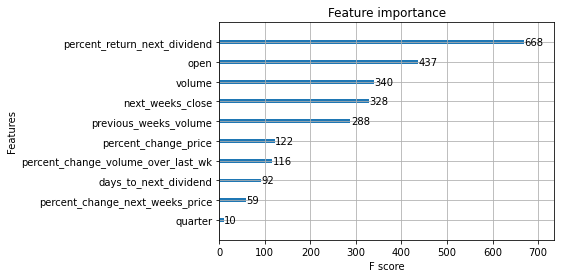

In [42]:
xgb.plot_importance(xgb_cl)
plt.show()

### Delete two columns: 'quarter', 'percent_change_next_weeks_price'

### XGB classifier on the dataset with 8 columns

In [43]:
df_work=df_work.drop(['quarter', 'percent_change_next_weeks_price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_work, labels_encoded, random_state=42, test_size=0.3)

xgb_cl_2=xgb.XGBClassifier(n_estimators=1000, n_jobs=-1, random_state=123)

xgb_cl_2.fit(X_train, y_train)
y_pred=xgb_cl_2.predict(X_test)
acc_score_xgb_2=accuracy_score(y_test, y_pred)

print('\nXGB Classifier with 8 features accuracy score= {:.4f}'.format(acc_score_xgb))

[23:59:02] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

XGB Classifier with 8 features accuracy score= 0.9333


### Decision tree Classifier on the dataset with 8 features

In [44]:
dt_with_8_columns=DecisionTreeClassifier()
dt_with_8_columns.fit(X_train, y_train)
y_pred=dt_with_8_columns.predict(X_test)

print('Accuracy score of decision tree classifier: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('Accuracy score of decision tree classifier on train set: {:.4f}'.format(accuracy_score(y_train, dt_with_8_columns.predict(X_train))))

Accuracy score of decision tree classifier: 0.9467
Accuracy score of decision tree classifier on train set: 1.0000


In [45]:
bc = BaggingClassifier(base_estimator=dt_with_8_columns, n_estimators=100, oob_score=True, random_state=1, n_jobs=-1)

bc.fit(X_train, y_train)
acc_score_bc=bc.oob_score_

print('Bugging Classifier oob_score: {:.4f}'.format(acc_score_bc))

C:\Users\andre\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Bugging Classifier oob_score: 0.9581


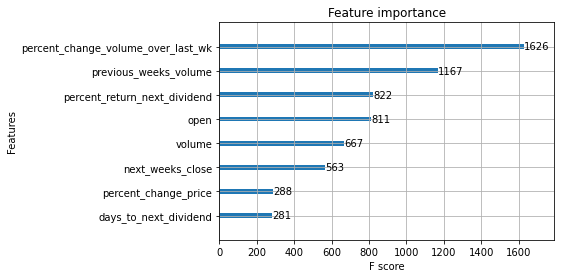

In [46]:
xgb.plot_importance(xgb_cl_2)
plt.show()

### Plot a Dendrogram to Hierarchical clustering model (temporarily will be not executed)

In [47]:
# for future
'''
distance_matrix=linkage(df_work)
dn=dendrogram(distance_matrix)
'''

'\ndistance_matrix=linkage(df_work)\ndn=dendrogram(distance_matrix)\n'

### Elbow plot for kmeans model

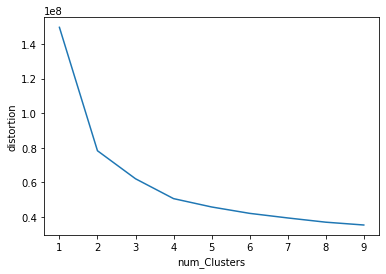

In [48]:
distortions=[]
num_clusters=range(1,10)
df_for_kmeans=df_work.copy(deep=True)
#df_for_kmeans=whiten(df_for_kmeans)

for i in num_clusters:
    cluster_center, distortion = kmeans(df_for_kmeans, i)
    distortions.append(distortion)

df_for_elbow_plot=pd.DataFrame({'num_Clusters':num_clusters, 'distortion':distortions})

sns.lineplot(x='num_Clusters', y='distortion', data=df_for_elbow_plot)
plt.show()

<AxesSubplot:xlabel='previous_weeks_volume', ylabel='volume'>

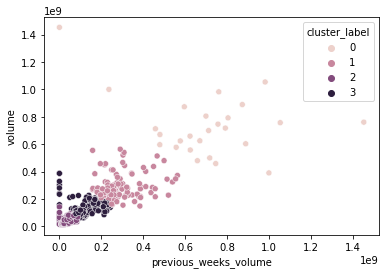

In [49]:
# For future models

cluster_center, _ = kmeans(df_for_kmeans, 4)
df_for_kmeans['cluster_label'], distortions_list = vq(df_for_kmeans, cluster_center)

sns.scatterplot(x='previous_weeks_volume', y='volume', hue='cluster_label', data=df_for_kmeans)

### The mean value of 'open' for each cluster (temporarily will be not executed)

In [50]:
'''
df_for_kmeans['stock']=labels

#df_temp = df_for_kmeans[df_for_kmeans['stock']=='AA']
df_for_kmeans.groupby('cluster_label')['open'].mean()
'''

"\ndf_for_kmeans['stock']=labels\n\n#df_temp = df_for_kmeans[df_for_kmeans['stock']=='AA']\ndf_for_kmeans.groupby('cluster_label')['open'].mean()\n"

### TSNE plot

C:\Users\andre\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


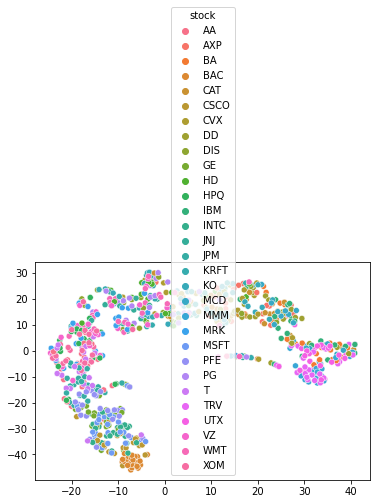

In [51]:
model_tsne=TSNE(learning_rate=50)
tsne_features=model_tsne.fit_transform(df_work)

x=tsne_features[:, 0]
y=tsne_features[:, 1]

sns.scatterplot(x, y, hue=labels)
plt.show()

### Pairplot with correlations

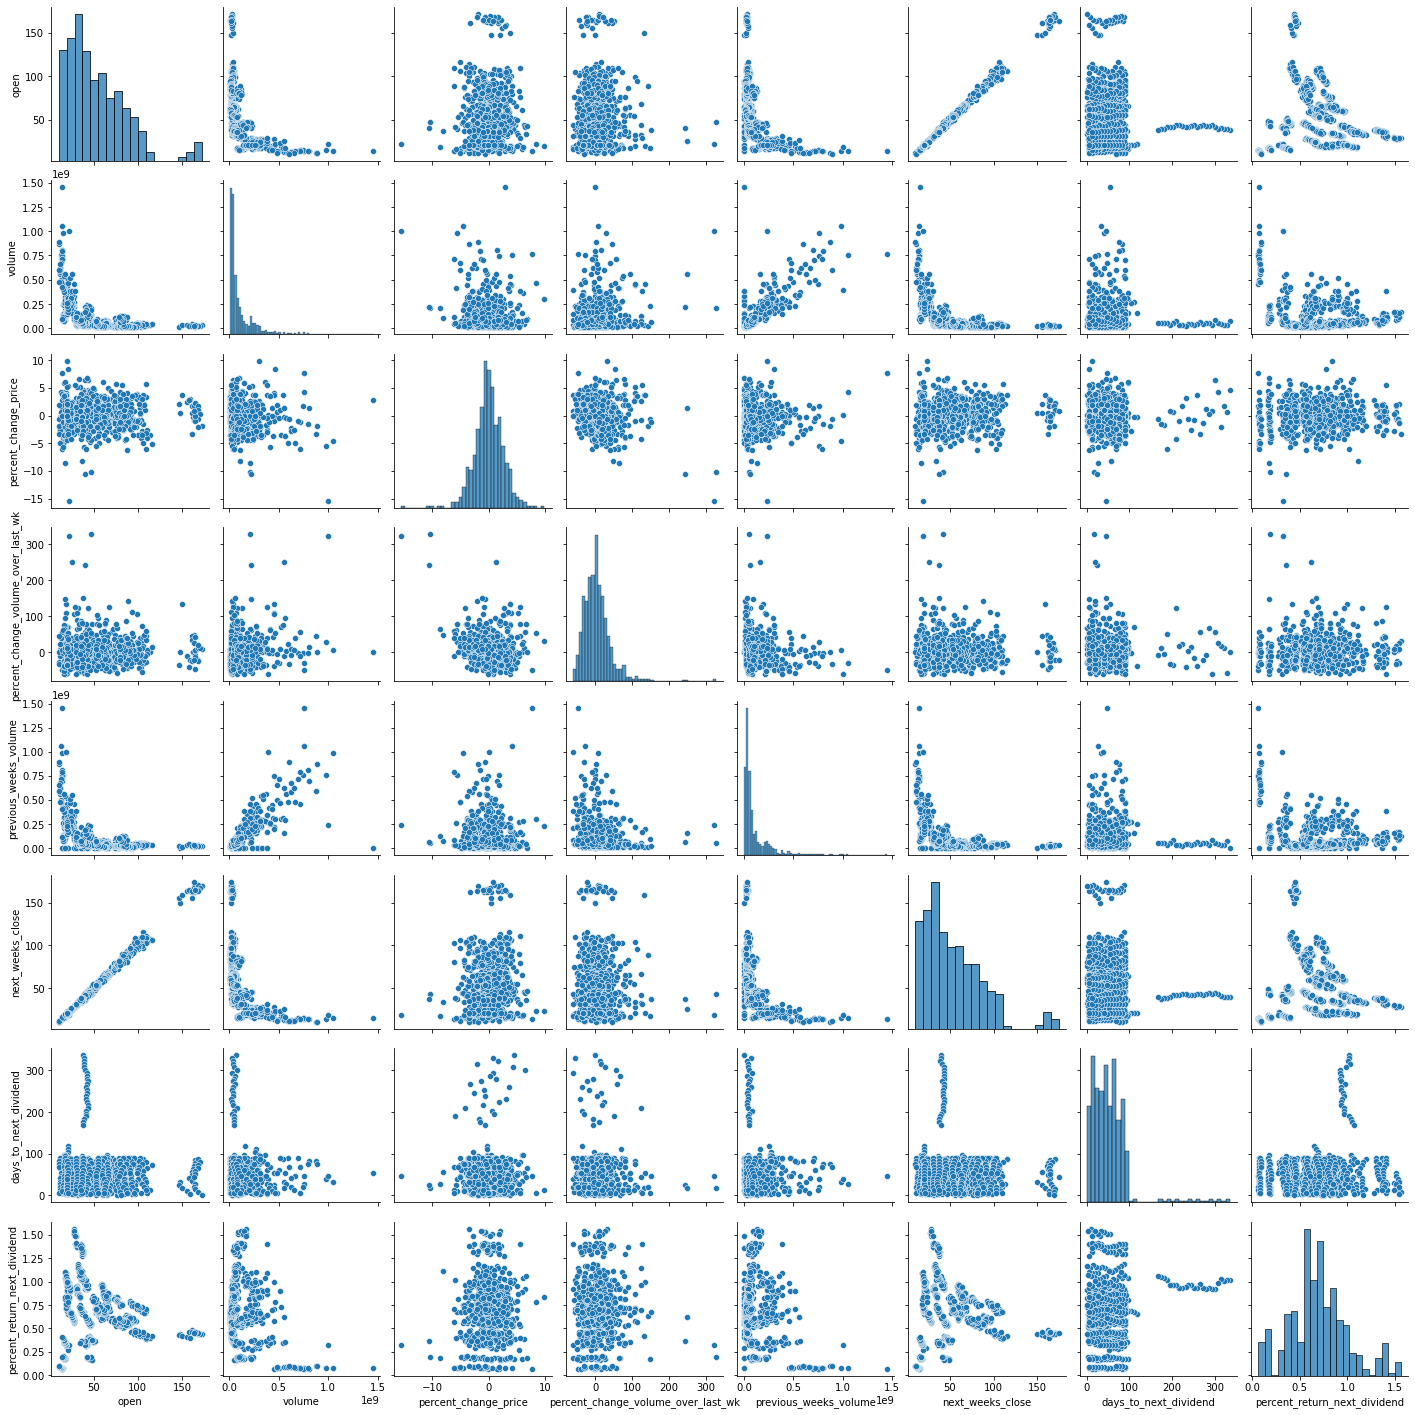

In [52]:
sns.pairplot(df_work)
plt.show()